In [27]:
# download the dataset
!curl -O https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv
!curl -O https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  703k  100  703k    0     0  1833k      0 --:--:-- --:--:-- --:--:-- 1846k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  8  184k    8 15461    0     0  51368      0  0:00:03 --:--:--  0:00:03 51536
100  184k  100  184k    0     0   542k      0 --:--:-- --:--:-- --:--:--  543k


In [28]:
# load the dataset
import pandas as pd
train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')

In [29]:
print("Number of training samples:", len(train_df))
print("Number of testing samples:", len(test_df))
print("Number of labels:", len(train_df.iloc[:,1].unique()))
print("Labels:", train_df.iloc[:,1].unique())

Number of training samples: 6919
Number of testing samples: 1820
Number of labels: 2
Labels: [0 1]


In [30]:
train_df

,"a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films",1
0,apparently reassembled from the cutting room f...,0
1,they presume their audience wo n't sit still f...,0
2,this is a visually stunning rumination on love...,1
3,jonathan parker 's bartleby should have been t...,1
4,campanella gets the tone just right funny in t...,1
...,...,...
6914,"painful , horrifying and oppressively tragic ,...",1
6915,take care is nicely performed by a quintet of ...,0
6916,"the script covers huge , heavy topics in a bla...",0
6917,a seriously bad film with seriously warped log...,0


In [31]:
test_df

,"no movement , no yuks , not much of anything",0
0,"a gob of drivel so sickly sweet , even the eag...",0
1,"gangs of new york is an unapologetic mess , wh...",0
2,"we never really feel involved with the story ,...",0
3,this is one of polanski 's best films,1
4,take care of my cat offers a refreshingly diff...,1
...,...,...
1815,"an often deadly boring , strange reading of a ...",0
1816,the problem with concept films is that if the ...,0
1817,"safe conduct , however ambitious and well inte...",0
1818,"a film made with as little wit , interest , an...",0


In [32]:
# Split the data into train and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df.iloc[:,1])
print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(val_df))

Number of training samples: 5535
Number of validation samples: 1384


In [33]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


In [34]:
import torch
import torch.nn as nn

In [35]:
# Construct MLP

class MLP(nn.Module):
    def __init__(self,input,output):
        super().__init__()
        self.layer1 = nn.Linear(input,512)
        self.layer2 = nn.Linear(512,256)
        self.layer3 = nn.Linear(256,128)
        self.layer4 = nn.Linear(128,64)
        self.layer5 = nn.Linear(64,output)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self,x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.layer5(x)

        return logits

In [36]:
model = MLP(10000,2)

In [37]:
# print model parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

layer1.weight torch.Size([512, 10000])
layer1.bias torch.Size([512])
layer2.weight torch.Size([256, 512])
layer2.bias torch.Size([256])
layer3.weight torch.Size([128, 256])
layer3.bias torch.Size([128])
layer4.weight torch.Size([64, 128])
layer4.bias torch.Size([64])
layer5.weight torch.Size([2, 64])
layer5.bias torch.Size([2])


In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total parameters: {total_params:,}")

Total parameters: 5,293,122


In [39]:
for name, param in model.named_parameters():
    print(f"{name} - dtype: {param.dtype}")

layer1.weight - dtype: torch.float32
layer1.bias - dtype: torch.float32
layer2.weight - dtype: torch.float32
layer2.bias - dtype: torch.float32
layer3.weight - dtype: torch.float32
layer3.bias - dtype: torch.float32
layer4.weight - dtype: torch.float32
layer4.bias - dtype: torch.float32
layer5.weight - dtype: torch.float32
layer5.bias - dtype: torch.float32


In [40]:
# tokenize the text
from sklearn.feature_extraction.text import CountVectorizer

train_texts = train_df.iloc[:,0].tolist()

vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_texts)

def tokenize_text(text, vectorizer):
    return vectorizer.transform([text]).toarray()[0]


In [41]:
# tokenize the train set and train labels

train_texts_vectorized = [tokenize_text(text, vectorizer) for text in train_texts]
train_labels = train_df.iloc[:,1].tolist()

train_texts_vectorized = torch.tensor(train_texts_vectorized, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)

# tokenize the validation set and validation labels

val_texts = val_df.iloc[:,0].tolist()
val_texts_vectorized = [tokenize_text(text, vectorizer) for text in val_texts]
val_labels = val_df.iloc[:,1].tolist()

val_texts_vectorized = torch.tensor(val_texts_vectorized, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)

# tokenize the test set and test labels

test_texts = test_df.iloc[:,0].tolist()
test_texts_vectorized = [tokenize_text(text, vectorizer) for text in test_texts]
test_labels = test_df.iloc[:,1].tolist()

test_texts_vectorized = torch.tensor(test_texts_vectorized, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)


In [42]:
# train the model

import torch.optim as optim

criterion = nn.CrossEntropyLoss() # Pass the logits before the activation function
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

# Save the best model as checkpoint.pt based on validation loss
best_val_loss = float('inf')
val_loss_list = []
val_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_texts_vectorized)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    print(f"\nEpoch {epoch+1}/{num_epochs}\nTrain Loss: {loss.item()}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_texts_vectorized)
        val_loss = criterion(val_outputs, val_labels)
        val_loss_list.append(val_loss.item())
        val_predictions = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_predictions == val_labels).float().mean().item()
        val_accuracy_list.append(val_accuracy)
        print(f"Validation Loss: {val_loss.item()}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'checkpoint.pt')
            print(f"Validation loss improved, saving model to checkpoint.pt")



Epoch 1/10
Train Loss: 0.6960154175758362
Validation Loss: 0.6944561004638672
Validation loss improved, saving model to checkpoint.pt

Epoch 2/10
Train Loss: 0.693789005279541
Validation Loss: 0.6927558779716492
Validation loss improved, saving model to checkpoint.pt

Epoch 3/10
Train Loss: 0.6913817524909973
Validation Loss: 0.690915048122406
Validation loss improved, saving model to checkpoint.pt

Epoch 4/10
Train Loss: 0.6885825395584106
Validation Loss: 0.6883177757263184
Validation loss improved, saving model to checkpoint.pt

Epoch 5/10
Train Loss: 0.6842949390411377
Validation Loss: 0.6843283176422119
Validation loss improved, saving model to checkpoint.pt

Epoch 6/10
Train Loss: 0.6772065162658691
Validation Loss: 0.6789509057998657
Validation loss improved, saving model to checkpoint.pt

Epoch 7/10
Train Loss: 0.6685348153114319
Validation Loss: 0.6722466349601746
Validation loss improved, saving model to checkpoint.pt

Epoch 8/10
Train Loss: 0.656557023525238
Validation Loss

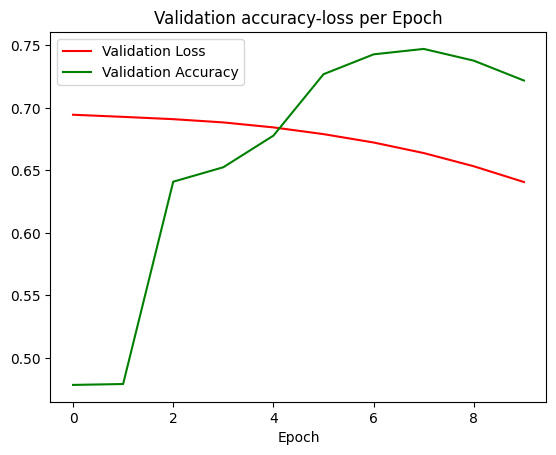

In [43]:
# plot the validation accuracy and loss per epoch
import matplotlib.pyplot as plt

plt.plot(val_loss_list, c='r', label='Validation Loss')
plt.plot(val_accuracy_list, c='g', label='Validation Accuracy')
plt.xlabel('Epoch')
# plt.ylabel('Loss')
plt.title('Validation accuracy-loss per Epoch')
plt.legend()
plt.show()

## Model Quantization

In [44]:
import time
import os

In [45]:
def model_info(model, type, test_texts_vectorized, test_labels):

    info = [type]

    model.eval()

    # Get model's accuracy
    model_output = model(test_texts_vectorized)
    model_predictions = torch.argmax(model_output, dim=1)
    model_accuracy = (model_predictions == test_labels).float().mean().item()
    info.append(model_accuracy*100)

    # Get model's size by making a temp directory and saving the model
    torch.save(model.state_dict(), 'temp_model.pt')
    model_size = os.path.getsize('temp_model.pt') / (1024 ** 2) # in MB
    os.remove('temp_model.pt')
    info.append(round(model_size,2))

    # Get model's average inference time for single example
    infer_times = []

    for _ in range(500):
      start_time = time.time()
      with torch.no_grad():
          model(test_texts_vectorized[0].unsqueeze(0))
      end_time = time.time()
      infer_times.append(end_time - start_time)

    inference_time = sum(infer_times) / len(infer_times)
    info.append(round(inference_time*1000, 2))

    return info

### Without Quantization

In [46]:
# load best model
best_model = MLP(10000,2)
best_model.load_state_dict(torch.load('checkpoint.pt'))

model_original_info_cpu = model_info(best_model, 'Original (CPU)',test_texts_vectorized,test_labels)

device = torch.device("cuda")
best_model.to(device)
test_texts_vectorized_device = test_texts_vectorized.to(device)
test_labels_device = test_labels.to(device)
model_original_info_gpu = model_info(best_model, 'Original (T4 GPU)',test_texts_vectorized_device,test_labels_device)

### Dynamic Quantization with INT8

In [47]:
import torch.quantization as quantization

In [48]:
# load best model
best_model = MLP(10000,2)
best_model.load_state_dict(torch.load('checkpoint.pt'))

# Dynamic Quantization with INT4
model_int4 = quantization.quantize_dynamic(best_model, {nn.Linear}, dtype=torch.qint8)

model_int4_info_cpu = model_info(model_int4, 'Dynamic (CPU ONLY)',test_texts_vectorized,test_labels)
# model_int4_info_gpu = model_info(model_int4, 'Dynamic', "cuda")


### Half precision

In [49]:
# load best model
best_model = MLP(10000,2)
best_model.load_state_dict(torch.load('checkpoint.pt'))

# Half Precision
model_half = best_model.half()
test_texts_vectorized_half = test_texts_vectorized.half()
test_labels_half = test_labels.half()

model_half_info_cpu = model_info(model_half, 'Half (CPU)', test_texts_vectorized_half,test_labels_half)

device = torch.device("cuda")
best_model.to(device)
test_texts_vectorized_half_device = test_texts_vectorized_half.to(device)
test_labels_half_device = test_labels_half.to(device)
model_half_info_gpu = model_info(model_half, 'Half (T4 GPU)', test_texts_vectorized_half_device,test_labels_half_device)

### Table with all the Information

In [50]:
# Generate the table with the results
import pandas as pd

columns = ['Model Name', 'Accuracy (%)', 'Size (MB)', 'Inference Time (ms)']
data = [model_original_info_cpu,model_int4_info_cpu, model_half_info_cpu,model_original_info_gpu, model_half_info_gpu]
df = pd.DataFrame(data, columns=columns)

In [51]:
print("\nRESULTS")
display(df)


RESULTS


,Model Name,Accuracy (%),Size (MB),Inference Time (ms)
0,Original (CPU),73.296702,20.20,0.99
1,Dynamic (CPU ONLY),73.351645,5.06,0.94
2,Half (CPU),73.296702,10.10,0.27
3,Original (T4 GPU),73.296708,20.20,0.32
4,Half (T4 GPU),73.296708,10.10,0.30


In [52]:
!cat /proc/cpuinfo

'cat' is not recognized as an internal or external command,
operable program or batch file.


In [53]:
!wmic cpu get name,NumberOfCores,NumberOfLogicalProcessors

Name                                        NumberOfCores  NumberOfLogicalProcessors  

AMD Ryzen 7 7840HS w/ Radeon 780M Graphics  8              16                         





In [54]:
!Get-CimInstance Win32_Processor | Format-List *

'Get-CimInstance' is not recognized as an internal or external command,
operable program or batch file.
